# Phase 3 project

## Covid Dataset

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import joblib
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree

In [2]:
df_covid=pd.read_csv('Covid Data.csv')

In [3]:
df_covid

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


### Copying description from Kaggle

About Dataset
Context
Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.
During the entire course of the pandemic, one of the main problems that healthcare providers have faced is the shortage of medical resources and a proper plan to efficiently distribute them. In these tough times, being able to predict what kind of resource an individual might require at the time of being tested positive or even before that will be of immense help to the authorities as they would be able to procure and arrange for the resources necessary to save the life of that patient.

The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current symptom, status, and medical history, will predict whether the patient is in high risk or not.

### content
The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

* sex: 1 for female and 2 for male.
* age: of the patient.
* classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
* patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
* pneumonia: whether the patient already have air sacs inflammation or not.
* pregnancy: whether the patient is pregnant or not.
* diabetes: whether the patient has diabetes or not.
* copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
* asthma: whether the patient has asthma or not.
* inmsupr: whether the patient is immunosuppressed or not.
* hypertension: whether the patient has hypertension or not.
* cardiovascular: whether the patient has heart or blood vessels related disease.
* renal chronic: whether the patient has chronic renal disease or not.
* other disease: whether the patient has other disease or not.
* obesity: whether the patient is obese or not.
* tobacco: whether the patient is a tobacco user.
* usmr: Indicates whether the patient treated medical units of the first, second or third level.
* medical unit: type of institution of the National Health System that provided the care.
* intubed: whether the patient was connected to the ventilator.
* icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
* date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

I need to decide which one should be the target variable. The possible ones are:
'classification', 'patient type', 'usmr', 'medical unit', 'icu', 'date died'

In [4]:
df_covid.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

In [5]:
df_covid['USMER'].value_counts

<bound method IndexOpsMixin.value_counts of 0          2
1          2
2          2
3          2
4          2
          ..
1048570    2
1048571    1
1048572    2
1048573    2
1048574    2
Name: USMER, Length: 1048575, dtype: int64>

In [6]:
df_covid['USMER'].value_counts(normalize=True)

2    0.632194
1    0.367806
Name: USMER, dtype: float64

In [7]:
df_covid['CLASIFFICATION_FINAL'].value_counts(normalize=True)

7    0.476122
3    0.363853
6    0.122197
5    0.024882
1    0.008203
4    0.002977
2    0.001765
Name: CLASIFFICATION_FINAL, dtype: float64

I would need to do a groupby here because values 1-3 mean they had covid, 4 and up no covid.
I think whichever target variable I choose I have to remove all the other info we have about the patient having covid.

In [8]:
df_covid['PATIENT_TYPE'].value_counts(normalize=True)

1    0.809235
2    0.190765
Name: PATIENT_TYPE, dtype: float64

This could be good but it is imbalanced. But maybe even like this it is ok.

In [9]:
df_covid['MEDICAL_UNIT'].value_counts(normalize=True)

12    0.575061
4     0.299840
6     0.038704
9     0.036350
3     0.018287
8     0.009917
10    0.007508
5     0.006908
11    0.005319
13    0.000950
7     0.000850
2     0.000161
1     0.000144
Name: MEDICAL_UNIT, dtype: float64

In [10]:
# Not very informative

In [11]:
df_covid['ICU'].value_counts(normalize=True)

97    0.809235
2     0.167546
1     0.016077
99    0.007141
Name: ICU, dtype: float64

In [12]:
# Mostly missing values

In [13]:
df_covid['DATE_DIED'].value_counts(normalize=True)

9999-99-99    9.266223e-01
06/07/2020    9.536752e-04
07/07/2020    9.498605e-04
13/07/2020    9.441385e-04
16/06/2020    9.336480e-04
                  ...     
08/12/2020    9.536752e-07
02/04/2021    9.536752e-07
07/10/2020    9.536752e-07
07/03/2021    9.536752e-07
15/11/2020    9.536752e-07
Name: DATE_DIED, Length: 401, dtype: float64

In [14]:
# Mostly missing values

Stays standing 'classification', 'patient type'

To make the decision between these two variables we did some research to gain some domain knowledge and spoke directly to some first responders during the covid 19 pandemic, that suggested that the information about whether or not a patient needed to be hospitalized was more valuable than the results of the covid test.
This is the case since some patients might have tested positive for covid 19, but because of mild symptoms and overall good health were sent back home to be treated, and what actually really put a strain on health structures was the number of people in need to be hospitalized. Because of this we are going to use 'patient type' as our target for this study.
We are also going to drop all the other variables related to hospitalization since those contain knowledge about the hospitalization of the patient, while what we are trying to predict is the amout of people that would need to be hospitalized, based on previous knowledge so this is not a type of information we would have, if we wanted to use the model again on other data.

So target should be patient type and all the other hospital related variables should be dropped.

In [15]:
df_covid

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


In [16]:
df_covid.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

In [17]:
df=df_covid.drop(['USMER', 'MEDICAL_UNIT', 'INTUBED', 'CLASIFFICATION_FINAL', 'ICU', 'DATE_DIED'], axis=1)

In [18]:
df

,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1,1,1,65,2,2,2,2,2,1,2,2,2,2,2
1,2,1,1,72,97,2,2,2,2,1,2,2,1,1,2
2,2,2,2,55,97,1,2,2,2,2,2,2,2,2,2
3,1,1,2,53,2,2,2,2,2,2,2,2,2,2,2
4,2,1,2,68,97,1,2,2,2,1,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,1,2,40,97,2,2,2,2,2,2,2,2,2,2
1048571,2,2,2,51,97,2,2,2,2,1,2,2,2,2,2
1048572,2,1,2,55,97,2,2,2,2,2,2,2,2,2,2
1048573,2,1,2,28,97,2,2,2,2,2,2,2,2,2,2


The missing values are catalogued as 97 or 99. So I have to look for these values to understand how many null values.

In [19]:
df['SEX'].value_counts(normalize=True)

1    0.500741
2    0.499259
Name: SEX, dtype: float64

In [20]:
df['PREGNANT'].value_counts(normalize=True)

97    0.499259
2     0.489406
1     0.007754
98    0.003580
Name: PREGNANT, dtype: float64

Will need to find a way to replace the missing values for pregnant.

In [21]:
for i in df.columns:
    print(i,'\n', df[i].value_counts(normalize=True))

SEX 
 1    0.500741
2    0.499259
Name: SEX, dtype: float64
PATIENT_TYPE 
 1    0.809235
2    0.190765
Name: PATIENT_TYPE, dtype: float64
PNEUMONIA 
 2     0.851188
1     0.133551
99    0.015262
Name: PNEUMONIA, dtype: float64
AGE 
 30     2.575877e-02
31     2.472594e-02
28     2.414038e-02
29     2.396967e-02
34     2.371981e-02
           ...     
115    1.907350e-06
114    1.907350e-06
113    9.536752e-07
111    9.536752e-07
121    9.536752e-07
Name: AGE, Length: 121, dtype: float64
PREGNANT 
 97    0.499259
2     0.489406
1     0.007754
98    0.003580
Name: PREGNANT, dtype: float64
DIABETES 
 2     0.877618
1     0.119199
98    0.003183
Name: DIABETES, dtype: float64
COPD 
 2     0.982772
1     0.014364
98    0.002864
Name: COPD, dtype: float64
ASTHMA 
 2     0.967050
1     0.030109
98    0.002841
Name: ASTHMA, dtype: float64
INMSUPR 
 2     0.983240
1     0.013514
98    0.003246
Name: INMSUPR, dtype: float64
HIPERTENSION 
 2     0.841849
1     0.155191
98    0.002960
Name: HIPERT

97, 98 and 99 represent missing values for all the columns except 'AGE'.
<br>For some categories the missing values are so little that it's worth just dropping them. For the two categories with the most missing values, 'PREGNANT' and 'PNEUMONIA' I will proceed to impute them.
<br>I want to replace them but since most values are categorical I want to replace them not just with the mode but keeping the same percentage of values from the original data.
<br>We will use the percentages that we see in the above value counts.

In [22]:
age=df['AGE']

In [23]:
df.drop('AGE', axis=1, inplace=True)

In [24]:
for i in df.columns:
    df[i]=df[i].replace([97,98,99], np.NaN)

In [25]:
df.isna().sum()

SEX                    0
PATIENT_TYPE           0
PNEUMONIA          16003
PREGNANT          527265
DIABETES            3338
COPD                3003
ASTHMA              2979
INMSUPR             3404
HIPERTENSION        3104
OTHER_DISEASE       5045
CARDIOVASCULAR      3076
OBESITY             3032
RENAL_CHRONIC       3006
TOBACCO             3220
dtype: int64

In [26]:
"""I could replace the missing values using percentages OR I could do it using KNN OR I could do it direclty in the decision tree/random forest.
For now let me replace them in this easier percentage way, then if I have time later I will try the other two ways."""

'I could replace the missing values using percentages OR I could do it using KNN OR I could do it direclty in the decision tree/random forest.\nFor now let me replace them in this easier percentage way, then if I have time later I will try the other two ways.'

In [27]:
df['PREGNANT'] =df['PREGNANT'].fillna(pd.Series(np.random.choice([1, 2], 
                                    p=[0.02,0.98],size=len(df))))

In [28]:
df['PNEUMONIA'] =df['PNEUMONIA'].fillna(pd.Series(np.random.choice([1, 2], 
                                    p=[0.14,0.86],size=len(df))))

In [29]:
df=pd.concat([df, age], axis=1)

In [30]:
df.dropna(inplace=True)

In [31]:
df.isna().sum()

SEX               0
PATIENT_TYPE      0
PNEUMONIA         0
PREGNANT          0
DIABETES          0
COPD              0
ASTHMA            0
INMSUPR           0
HIPERTENSION      0
OTHER_DISEASE     0
CARDIOVASCULAR    0
OBESITY           0
RENAL_CHRONIC     0
TOBACCO           0
AGE               0
dtype: int64

In [32]:
df

,SEX,PATIENT_TYPE,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,1,1,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,65
1,2,1,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,72
2,2,2,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,55
3,1,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,53
4,2,1,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,40
1048571,2,2,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,51
1048572,2,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,55
1048573,2,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,28


Now to follow the usual convention of one hot encoding I want to change the values 2 which means no into 0.
<br>This is true for all the columns except our target, 'PATIENT_TYPE' where 1 means they returned home and 2 means they were hospitalized. I will do this separately, and then assign the column to y.
For X I will do the necessary changes to df and then concat with 'AGE' that I dropped before.
<br>For sex it is going to be 1 for female and 0 for male.

In [33]:
y=df['PATIENT_TYPE']

In [34]:
#I have to redifine age again because the old onw has some null values that I dropped.
age=df['AGE']

In [35]:
df.drop(['PATIENT_TYPE','AGE'], axis=1, inplace=True)

In [36]:
df=df.replace(2, 0)

In [37]:
df

,SEX,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048571,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1048572,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048573,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
for i in df.columns:
    print(i,'\n', df[i].value_counts(normalize=True))

SEX 
 1    0.501223
0    0.498777
Name: SEX, dtype: float64
PNEUMONIA 
 0.0    0.865694
1.0    0.134306
Name: PNEUMONIA, dtype: float64
PREGNANT 
 0.0    0.982059
1.0    0.017941
Name: PREGNANT, dtype: float64
DIABETES 
 0.0    0.880903
1.0    0.119097
Name: DIABETES, dtype: float64
COPD 
 0.0    0.985699
1.0    0.014301
Name: COPD, dtype: float64
ASTHMA 
 0.0    0.969851
1.0    0.030149
Name: ASTHMA, dtype: float64
INMSUPR 
 0.0    0.98656
1.0    0.01344
Name: INMSUPR, dtype: float64
HIPERTENSION 
 0.0    0.844846
1.0    0.155154
Name: HIPERTENSION, dtype: float64
OTHER_DISEASE 
 0.0    0.973249
1.0    0.026751
Name: OTHER_DISEASE, dtype: float64
CARDIOVASCULAR 
 0.0    0.980277
1.0    0.019723
Name: CARDIOVASCULAR, dtype: float64
OBESITY 
 0.0    0.847613
1.0    0.152387
Name: OBESITY, dtype: float64
RENAL_CHRONIC 
 0.0    0.982013
1.0    0.017987
Name: RENAL_CHRONIC, dtype: float64
TOBACCO 
 0.0    0.919502
1.0    0.080498
Name: TOBACCO, dtype: float64


Changing to zero and 1 for the target:

In [39]:
y=y.replace(1,0)
y=y.replace(2, 1)
y

0          0
1          0
2          1
3          0
4          0
          ..
1048570    0
1048571    1
1048572    0
1048573    0
1048574    0
Name: PATIENT_TYPE, Length: 1041013, dtype: int64

In [40]:
y.value_counts()

0    844063
1    196950
Name: PATIENT_TYPE, dtype: int64

In [41]:
X=pd.concat([df,age], axis=1)

In [42]:
X

,SEX,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,AGE
0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65
1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,72
2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53
4,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
1048571,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,51
1048572,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
1048573,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28


At this point I took care of the missing values and I don't need to do one hot encoding.
<br>I have my X and y, I can divide in train and test and start trying some models.
<br>But if I want to use KNN first (and I do) I have to scale first, specifically age needs to be scaled.

In [43]:
"""Another thing I could try later to improve the model is instead of scaling the age to divide it into bins. Like 10 years for each bin and one hot encode that."""

'Another thing I could try later to improve the model is instead of scaling the age to divide it into bins. Like 10 years for each bin and one hot encode that.'

In [44]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [45]:
"""
Just to Kind of make a point that I dont actually eed to scale
# Instantiate StandardScaler
scaler = MinMaxScaler()
# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
X_train = pd.DataFrame(scaled_data_train, columns=X.columns)
X_train.head()"""

'\nJust to Kind of make a point that I dont actually eed to scale\n# Instantiate StandardScaler\nscaler = MinMaxScaler()\n# Transform the training and test sets\nscaled_data_train = scaler.fit_transform(X_train)\nscaled_data_test = scaler.transform(X_test)\n\n# Convert into a DataFrame\nX_train = pd.DataFrame(scaled_data_train, columns=X.columns)\nX_train.head()'

In [46]:
#Create the tree
clf = DecisionTreeClassifier(criterion='entropy')

In [48]:
# fit the tree
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [57]:
# plot the tree
fig, axes = plt.subplots()#nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(clf,
               feature_names = X_train.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

KeyboardInterrupt: 

In [58]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

Precision Score: 0.8055683699221188
Recall Score: 0.6027369446926013
Accuracy Score: 0.8972888024775796
F1 Score: 0.6895462411298097


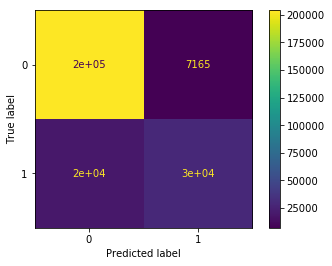

In [60]:
# Evaluate the tree
# Still not sure if here I should do everything with test or train
y_preds = clf.predict(X_test)

print_metrics(y_test, y_preds)

plot_confusion_matrix(clf,X_test,y_test);

In [63]:
# Feature Importance
feature_used = df.columns
for fi, feature in zip(clf.feature_importances_, feature_used):
    print(fi, feature)

0.01097621890975523 SEX
0.7086876313709721 PNEUMONIA
0.005861511912350925 PREGNANT
0.023110821955634332 DIABETES
0.005051839579396929 COPD
0.005845607276465881 ASTHMA
0.010842264746763086 INMSUPR
0.00820169573543966 HIPERTENSION
0.009877110371956266 OTHER_DISEASE
0.006201286643343213 CARDIOVASCULAR
0.009489018534248555 OBESITY
0.012133400540513057 RENAL_CHRONIC
0.007610094070922553 TOBACCO


In [ ]:

    
print_metrics(y_test, test_preds)

y_hat = loaded_model.predict(X_train)

plot_confusion_matrix(confusion_matrix(y_train, y_hat), )

This is not so bad as a result. But given our situation I would actually like to have a higher recall than accuracy. With a high recall it means I am getting more false positives because I am decreasing the thershold, but that is what I want most times in 'medical situations', because I would rather have a false positive than a false negative.

Now I have to figure out how to decrease this famous threshold in decision trees.